In [2]:
import os
import random
import javalang
import javalang.tree
import javalang.ast
import javalang.util
from javalang.ast import Node
import torch
from anytree import AnyNode, RenderTree
#import treelib
from anytree import find
from createclone_java import getedge_nextsib,getedge_flow,getedge_nextstmt,getedge_nexttoken,getedge_nextuse

def get_token(node):
    token = ''
    #print(isinstance(node, Node))
    #print(type(node))
    if isinstance(node, str):
        token = node
    elif isinstance(node, set):
        token = 'Modifier'
    elif isinstance(node, Node):
        token = node.__class__.__name__
    #print(node.__class__.__name__,str(node))
    #print(node.__class__.__name__, node)
    return token
def get_child(root):
    #print(root)
    if isinstance(root, Node):
        children = root.children
    elif isinstance(root, set):
        children = list(root)
    else:
        children = []

    def expand(nested_list):
        for item in nested_list:
            if isinstance(item, list):
                for sub_item in expand(item):
                    #print(sub_item)
                    yield sub_item
            elif item:
                #print(item)
                yield item
    return list(expand(children))
def get_sequence(node, sequence):
    token, children = get_token(node), get_child(node)
    sequence.append(token)
    #print(len(sequence), token)
    for child in children:
        get_sequence(child, sequence)

def getnodes(node,nodelist):
    nodelist.append(node)
    children = get_child(node)
    for child in children:
        getnodes(child,nodelist)

def createtree(root,node,nodelist,parent=None):
    id = len(nodelist)
    #print(id)
    token, children = get_token(node), get_child(node)
    if id==0:
        root.token=token
        root.data=node
    else:
        newnode=AnyNode(id=id,token=token,data=node,parent=parent)
    nodelist.append(node)
    for child in children:
        if id==0:
            createtree(root,child, nodelist, parent=root)
        else:
            createtree(root,child, nodelist, parent=newnode)
def getnodeandedge_astonly(node,nodeindexlist,vocabdict,src,tgt):
    token=node.token
    nodeindexlist.append([vocabdict[token]])
    for child in node.children:
        src.append(node.id)
        tgt.append(child.id)
        src.append(child.id)
        tgt.append(node.id)
        getnodeandedge_astonly(child,nodeindexlist,vocabdict,src,tgt)
def getnodeandedge(node,nodeindexlist,vocabdict,src,tgt,edgetype):
    token=node.token
    nodeindexlist.append([vocabdict[token]])
    for child in node.children:
        src.append(node.id)
        tgt.append(child.id)
        edgetype.append([0])
        src.append(child.id)
        tgt.append(node.id)
        edgetype.append([0])
        getnodeandedge(child,nodeindexlist,vocabdict,src,tgt,edgetype)

def countnodes(node,ifcount,whilecount,forcount,blockcount):
    token=node.token
    if token=='IfStatement':
        ifcount+=1
    if token=='WhileStatement':
        whilecount+=1
    if token=='ForStatement':
        forcount+=1
    if token=='BlockStatement':
        blockcount+=1
    print(ifcount,whilecount,forcount,blockcount)
    for child in node.children:
        countnodes(child,ifcount,whilecount,forcount,blockcount)
'''def getedge_nextsib(node,vocabdict,src,tgt,edgetype):
    token=node.token
    for i in range(len(node.children)-1):
        src.append(node.children[i].id)
        tgt.append(node.children[i+1].id)
        edgetype.append([1])
        src.append(node.children[i+1].id)
        tgt.append(node.children[i].id)
        edgetype.append([1])
    for child in node.children:
        getedge_nextsib(child,vocabdict,src,tgt,edgetype)'''
def createast():
    asts=[]
    paths=[]
    alltokens=[]
    dirname = 'BCB/bigclonebenchdata/'
    # dirname = 'BCB/test/'
    for rt, dirs, files in os.walk(dirname):
        for file in files:
            programfile=open(os.path.join(rt,file),encoding='utf-8')
            #print(os.path.join(rt,file))
            programtext=programfile.read()
            #programtext=programtext.replace('\r','')
            programtokens=javalang.tokenizer.tokenize(programtext)
            #print(list(programtokens))
            parser=javalang.parse.Parser(programtokens)
            programast=parser.parse_member_declaration()
            paths.append(os.path.join(rt,file))
            asts.append(programast)
            get_sequence(programast,alltokens)
            programfile.close()
            #print(programast)
            #print(alltokens)
    astdict=dict(zip(paths,asts))
    ifcount=0
    whilecount=0
    forcount=0
    blockcount=0
    docount = 0
    switchcount = 0
    for token in alltokens:
        if token=='IfStatement':
            ifcount+=1
        if token=='WhileStatement':
            whilecount+=1
        if token=='ForStatement':
            forcount+=1
        if token=='BlockStatement':
            blockcount+=1
        if token=='DoStatement':
            docount+=1
        if token=='SwitchStatement':
            switchcount+=1
    print(ifcount,whilecount,forcount,blockcount,docount,switchcount)
    print('allnodes ',len(alltokens))
    alltokens=list(set(alltokens))
    vocabsize = len(alltokens)
    tokenids = range(vocabsize)
    vocabdict = dict(zip(alltokens, tokenids))
    print(vocabsize)
    return astdict,vocabsize,vocabdict

def createseparategraph(astdict,vocablen,vocabdict,device,mode='astonly',nextsib=False,ifedge=False,whileedge=False,foredge=False,blockedge=False,nexttoken=False,nextuse=False):
    pathlist=[]
    treelist=[]
    print('nextsib ',nextsib)
    print('ifedge ',ifedge)
    print('whileedge ',whileedge)
    print('foredge ',foredge)
    print('blockedge ',blockedge)
    print('nexttoken', nexttoken)
    print('nextuse ',nextuse)
    print(len(astdict))
    for path,tree in astdict.items():
        #print(tree)
        #print(path)
        nodelist = []
        newtree=AnyNode(id=0,token=None,data=None)
        createtree(newtree, tree, nodelist)
        #print(path)
        #print(newtree)
        x = []
        edgesrc = []
        edgetgt = []
        edge_attr=[]
        if mode=='astonly':
            getnodeandedge_astonly(newtree, x, vocabdict, edgesrc, edgetgt)
        else:
            getnodeandedge(newtree, x, vocabdict, edgesrc, edgetgt,edge_attr)
            if nextsib==True:
                getedge_nextsib(newtree,vocabdict,edgesrc,edgetgt,edge_attr)
            getedge_flow(newtree,vocabdict,edgesrc,edgetgt,edge_attr,ifedge,whileedge,foredge)
            if blockedge==True:
                getedge_nextstmt(newtree,vocabdict,edgesrc,edgetgt,edge_attr)
            tokenlist=[]
            if nexttoken==True:
                getedge_nexttoken(newtree,vocabdict,edgesrc,edgetgt,edge_attr,tokenlist)
            variabledict={}
            if nextuse==True:
                getedge_nextuse(newtree,vocabdict,edgesrc,edgetgt,edge_attr,variabledict)
        #x = torch.tensor(x, dtype=torch.long, device=device)
        edge_index=[edgesrc, edgetgt]
        #edge_index = torch.tensor([edgesrc, edgetgt], dtype=torch.long, device=device)
        astlength=len(x)
        #print(x)
        #print(edge_index)
        #print(edge_attr)
        pathlist.append(path)
        treelist.append([[x,edge_index,edge_attr],astlength])
        astdict[path]=[[x,edge_index,edge_attr],astlength]
    #treedict=dict(zip(pathlist,treelist))
    #print(totalif,totalwhile,totalfor,totalblock)
    return astdict
def creategmndata(id,treedict,vocablen,vocabdict,device):
    indexdir='BCB/'
    if id=='0':
        trainfile = open(indexdir+'traindata.txt')
        validfile = open(indexdir+'devdata.txt')
        testfile = open(indexdir+'testdata.txt')
    elif id=='11':
        trainfile = open(indexdir+'traindata11.txt')
        validfile = open(indexdir+'devdata.txt')
        testfile = open(indexdir+'testdata.txt')
    else:
        print('file not exist')
        quit()
    trainlist=trainfile.readlines()
    validlist=validfile.readlines()
    testlist=testfile.readlines()
    traindata=[]
    validdata=[]
    testdata=[]
    print('train data')
    traindata=createpairdata(treedict,trainlist,device=device)
    print('valid data')
    validdata=createpairdata(treedict,validlist,device=device)
    print('test data')
    testdata=createpairdata(treedict,testlist,device=device)
    return traindata, validdata, testdata

def createpairdata(treedict,pathlist,device):
    datalist=[]
    countlines=1
    for line in pathlist:
        #print(countlines)
        countlines += 1
        pairinfo = line.split()
        code1path='BCB'+pairinfo[0].strip('.')
        code2path='BCB'+pairinfo[1].strip('.')
        label=int(pairinfo[2])
        data1 = treedict[code1path]
        data2 = treedict[code2path]
        x1,edge_index1,edge_attr1,ast1length=data1[0][0],data1[0][1],data1[0][2],data1[1]
        x2,edge_index2,edge_attr2,ast2length=data2[0][0],data2[0][1],data2[0][2],data2[1]
        '''matchsrc = []
        matchtgt = []
        for i in range(ast1length):
            for j in range(ast2length):
                matchsrc.append(i)
                matchtgt.append(j)
        match_index=[matchsrc, matchtgt]'''
        #match_index = torch.tensor([matchsrc, matchtgt], dtype=torch.long, device=device)
        if edge_attr1==[]:
            edge_attr1 = None
            edge_attr2 = None
        data = [[x1, x2, edge_index1, edge_index2, edge_attr1, edge_attr2], label,[code1path,code2path]]
        datalist.append(data)
    return datalist

# if __name__ == '__main__':
#     astdict, vocabsize, vocabdict=createast()
#     treedict=createseparategraph(astdict, vocabsize, vocabdict,device='cpu',mode='else',nextsib=True,ifedge=True,whileedge=True,foredge=True,blockedge=True,nexttoken=True,nextuse=True)
#     #creategmndata(treedict,vocabsize,vocabdict,device='cpu')

In [3]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import time
import sys
import argparse
from tqdm import tqdm, trange
import pycparser
import models
from torch_geometric.data import Data, DataLoader
from torch.utils.tensorboard import SummaryWriter   
import argparse
# parser = argparse.ArgumentParser()

parser = argparse.ArgumentParser()
parser.add_argument("--cuda", default=True)
parser.add_argument("--dataset", default='gcj')
parser.add_argument("--graphmode", default='astandnext')
parser.add_argument("--nextsib", default=True)
parser.add_argument("--ifedge", default=True)
parser.add_argument("--whileedge", default=True)
parser.add_argument("--foredge", default=True)
parser.add_argument("--blockedge", default=True)
parser.add_argument("--nexttoken", default=True)
parser.add_argument("--nextuse", default=True)
parser.add_argument("--data_setting", default='11')
parser.add_argument("--batch_size", default=32)
parser.add_argument("--num_layers", default=4)
parser.add_argument("--num_epochs", default=10)
parser.add_argument("--lr", default=0.001)
parser.add_argument("--threshold", default=0.5)
# args = parser.parse_args()
args = parser.parse_known_args()[0]
device=torch.device('cuda:0')
#device=torch.device('cpu')
astdict,vocablen,vocabdict=createast()
treedict=createseparategraph(astdict, vocablen, vocabdict,device,mode=args.graphmode,nextsib=args.nextsib,ifedge=args.ifedge,whileedge=args.whileedge,foredge=args.foredge,blockedge=args.blockedge,nexttoken=args.nexttoken,nextuse=args.nextuse)
traindata,validdata,testdata=creategmndata(args.data_setting,treedict,vocablen,vocabdict,device)

24876 4024 3851 29899 130 109
allnodes  2205239
77535
nextsib  True
ifedge  True
whileedge  True
foredge  /home/dlf/.local/share/jupyter/runtime/kernel-v2-204107wN3y0d6A0ggx.json
blockedge  True
nexttoken True
nextuse  True
9133
train data
valid data
test data


In [37]:
import networkx as nx
import matplotlib.pyplot as plt

# 图可视化的代码
def visualize_graph(G,color):
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G,pos=nx.spring_layout(G,seed=42),with_labels=False,node_color=color,cmap="Set2")
    plt.show()


['BCB/bigclonebenchdata/10174077.txt', 'BCB/bigclonebenchdata/14757691.txt']
不相似


/home/dlf/miniconda3/envs/gnn_ast_flow/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


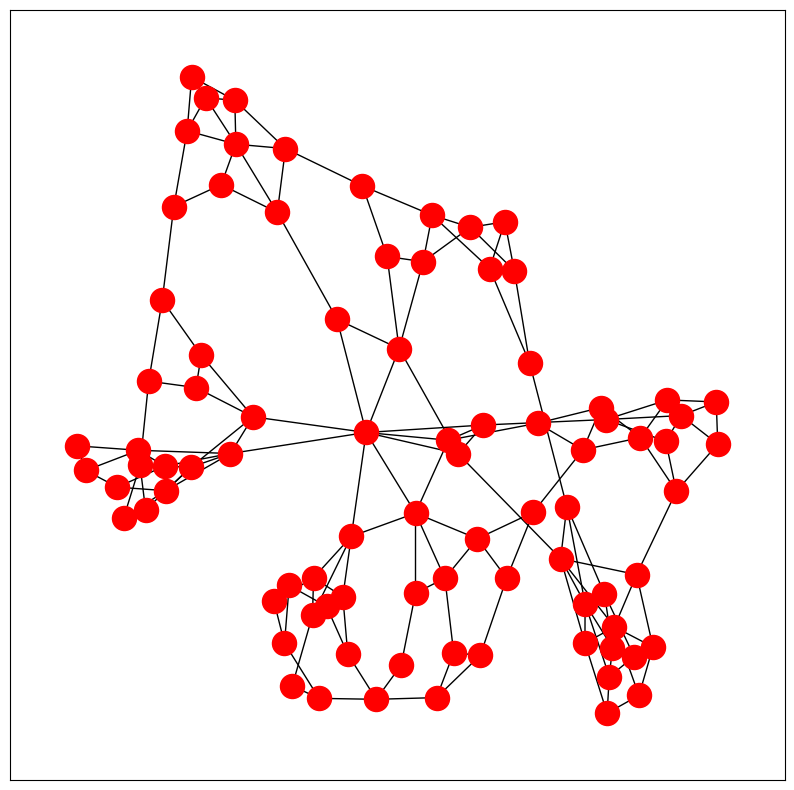

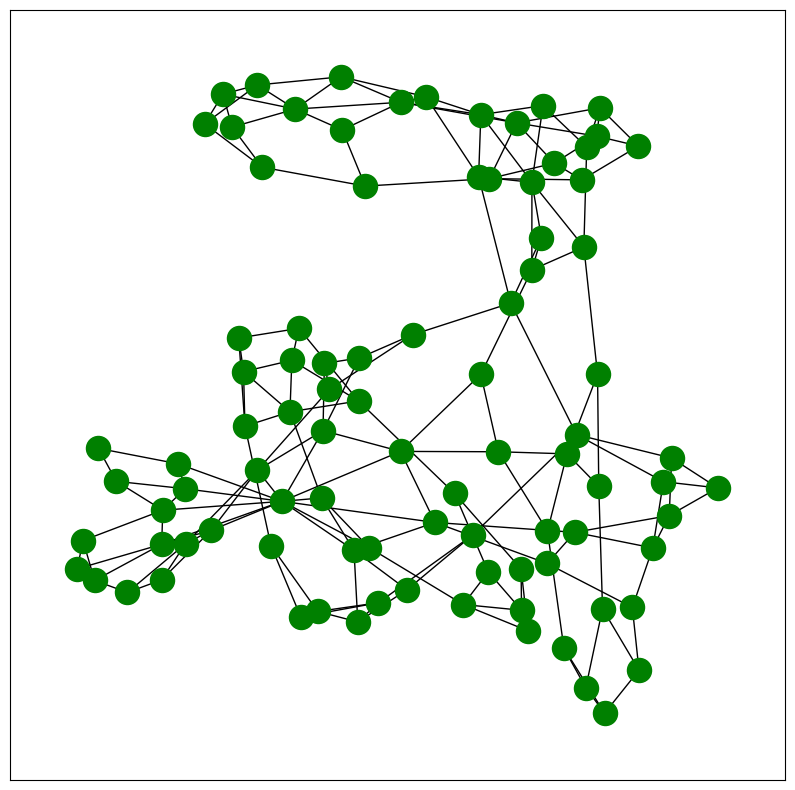

In [38]:
from torch_geometric.utils import to_networkx
data = traindata[13]

data,label,code_path = data
print(code_path)
x1, x2, edge_index1, edge_index2, edge_attr1, edge_attr2=data
x1=torch.tensor(x1, dtype=torch.long, device=device)
x2=torch.tensor(x2, dtype=torch.long, device=device)
edge_index1=torch.tensor(edge_index1, dtype=torch.long, device=device)
edge_index2=torch.tensor(edge_index2, dtype=torch.long, device=device)
if edge_attr1!=None:
    edge_attr1=torch.tensor(edge_attr1, dtype=torch.long, device=device)
    edge_attr2=torch.tensor(edge_attr2, dtype=torch.long, device=device)

print("相似" if label == 1 else "不相似")
from torch_geometric.data import Data
data2 = Data(x=x2,y=[label],edge_index=edge_index2,edge_attrs=edge_attr2,node_attrs=[])
data1 = Data(x=x1,y=[label],edge_index=edge_index1,edge_attrs=edge_attr1,node_attrs=[])

G = to_networkx(data1,to_undirected=True)
G2 = to_networkx(data2,to_undirected=True)
visualize_graph(G,color="red")
visualize_graph(G2,color="Green")

In [29]:
print(code_path)
item = code_path[1]
with open(item,"r") as f:
    for line in f.readlines():
        print(str(line).replace("\n",""))
# for item in code_path:
#     with open(item,"r") as f:
#         for line in f.readlines():
#             print(str(line).replace("\n",""))

['BCB/bigclonebenchdata/10174077.txt', 'BCB/bigclonebenchdata/14757691.txt']
    protected String getCitations(String ticket, String query) throws IOException {
        String urlQuery;
        try {
            urlQuery = "http://www.jstor.org/search/BasicResults?hp=" + MAX_CITATIONS + "&si=1&gw=jtx&jtxsi=1&jcpsi=1&artsi=1&Query=" + URLEncoder.encode(query, "UTF-8") + "&wc=on&citationAction=saveAll";
        } catch (UnsupportedEncodingException e) {
            throw new RuntimeException(e);
        }
        URL url = new URL(urlQuery);
        URLConnection conn = url.openConnection();
        conn.setRequestProperty("Cookie", ticket);
        return getCookie(COOKIE_CITATIONS, conn);
    }
